In [4]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['Times New Roman']
mpl.rcParams['axes.unicode_minus'] = False
current_path = os.getcwd()
print("current_path = ", current_path)

current_path =  F:\MissWelllog\main_article\Test_blind\Songliao


In [38]:
def normalize_data(path, save_path):
    """
    normalize the hdf5 file
    Args:
        path: (str）the hdf5 file path
        save_path: (str) save path of normalized data

    Returns:

    """
    GR_max = 250
    GR_min = 0
    AC_max = 400
    AC_min = 50
    CNL_max = 70
    CNL_min = 0
    RLLD_max = 4
    RLLD_min = -2
    DEN_max = 3.3
    DEN_min = 1.9
    f = h5py.File(name=path, mode="r")
    print(f.keys())
    AC = np.array(f.get("AC"))
    DEN = np.array(f.get("DEN"))
    RLLD = np.array(f.get("RLLD"))
    CNL = np.array(f.get("CNL"))
    GR = np.array(f.get("GR"))
    # RLLD = np.log10(RLLD)

    # maxmin normalize
    AC = (AC - AC_min) / (AC_max - AC_min)
    GR = (GR - GR_min) / (GR_max - GR_min)
    DEN = (DEN - DEN_min) / (DEN_max - DEN_min)
    RLLD = (RLLD - RLLD_min) / (RLLD_max - RLLD_min)
    CNL = (CNL - CNL_min) / (CNL_max - CNL_min)
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    f_normal = h5py.File(name=os.path.join(save_path, path), mode="w")
    f_normal.create_dataset("AC", data=AC)
    f_normal.create_dataset("DEN", data=DEN)
    f_normal.create_dataset("RLLD", data=RLLD)
    f_normal.create_dataset("CNL", data=CNL)
    f_normal.create_dataset("GR", data=GR)
    f_normal.create_dataset("DEPTH", data=np.array(f.get("DEPTH")))
    f.close()
    f_normal.close()


def split_data(path, save_path, mode="normal"):
    """
    Splitting the logging curve into sequence lengths 640 for prediction
    Args:
        path:(str）the hdf5 file path

    Returns:

    """
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    f = h5py.File(path, "r")
    AC = np.array(f.get("AC")).reshape(-1, )
    DEN = np.array(f.get("DEN")).reshape(-1, )
    GR = np.array(f.get("GR")).reshape(-1, )
    RLLD = np.array(f.get("RLLD")).reshape(-1, )
    CNL = np.array(f.get("CNL")).reshape(-1, )
    curve_len = len(AC)
    split_num = int(np.ceil(curve_len / 640))
    pad_len = split_num * 640
    GR_pad = np.zeros(pad_len, )
    GR_pad[:curve_len, ] = GR
    RLLD_pad = np.zeros(pad_len, )
    RLLD_pad[:curve_len, ] = RLLD
    CNL_pad = np.zeros(pad_len, )
    CNL_pad[:curve_len, ] = CNL
    AC_pad = np.zeros(pad_len, )
    AC_pad[:curve_len, ] = AC
    DEN_pad = np.zeros(pad_len, )
    DEN_pad[:curve_len, ] = DEN
    for i in range(split_num):
        AC_save = AC_pad[i * 640:(i + 1) * 640, ].reshape(-1, 1)
        DEN_save = DEN_pad[i * 640:(i + 1) * 640, ].reshape(-1, 1)
        GR_save = GR_pad[i * 640:(i + 1) * 640, ].reshape(-1, 1)
        CNL_save = CNL_pad[i * 640:(i + 1) * 640, ].reshape(-1, 1)
        RLLD_save = RLLD_pad[i * 640:(i + 1) * 640, ].reshape(-1, 1)
        # normalize
        if mode == 'normal':
            f_save = h5py.File(
                name=os.path.join(save_path, path.split(".")[1].split("\\")[1] + "_point_{}_{}.hdf5".format(i * 640, (
                        i + 1) * 640)),
                mode="w")
        # nonormalize
        if mode == 'nonormal':
            f_save = h5py.File(
                name=os.path.join(save_path,
                                  path.split(".")[0] + "_point_{}_{}.hdf5".format(i * 640, (i + 1) * 640)),
                mode="w")
        f_save.create_dataset("AC", data=AC_save)
        f_save.create_dataset("DEN", data=DEN_save)
        f_save.create_dataset("GR", data=GR_save)
        f_save.create_dataset("CNL", data=CNL_save)
        f_save.create_dataset("RLLD", data=RLLD_save)
        f_save.close()


def get_test_data_normal():
    paths = ["B1.hdf5", "B2.hdf5"]
    for path in paths:
        normalize_data(path, save_path="./normal")
    normalized_files = os.listdir("./normal")
    for file in normalized_files:
        split_data(os.path.join("./normal", file), save_path="./test_data_normal", mode="normal")
    print("Get normalized data in ./normal dir for prediction")


def get_test_data_nonormal():
    paths = ["B1.hdf5", "B2.hdf5"]
    for file in paths:
        split_data(file, save_path="./test_data_nonormal", mode="nonormal")
    print("Get nonormalized data in ./nonormal dir for prediction")

In [39]:
def concat_cut(pred_dir, save_path):
    well_name = ["B1.hdf5", "B2.hdf5"]
    for file in well_name:
        f = h5py.File(file, mode="r")
        AC = np.array(f.get("AC"))
        f.close()
        curve_len = len(AC.reshape(-1, ))
        split_num = int(np.ceil(curve_len / 640))
        pred_curve = []
        for i in range(split_num):
            f = h5py.File(
                os.path.join(pred_dir, file.split(".")[0] + "_point_{}_{}.hdf5".format(i * 640, (i + 1) * 640)),
                mode="r")
            pred = list(np.array(f.get("pred")).reshape(-1, ))
            pred_curve.extend(pred)
            f.close()
        f = h5py.File(name=file.split(".")[0] + "_" + save_path, mode="w")
        f.create_dataset(name="pred", data=pred_curve[:curve_len])
        f.close()

In [40]:
def Gardner_pred():
    data_dir = "./test_data_nonormal"
    save_dir = "./pred_gardner"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    files_list = os.listdir(data_dir)
    for file in files_list:
        path = os.path.join(data_dir, file)
        f = h5py.File(name=path, mode="r")
        AC = np.array(f.get("AC"))
        DEN = np.array(f.get("DEN"))
        vp = (1 / AC) / 0.3048 * 10 ** 6
        GDN_den = 0.23 * vp ** 0.25
        f_gdn = h5py.File(name=os.path.join(save_dir, file), mode="w")
        f_gdn.create_dataset(name="real", data=DEN)
        f_gdn.create_dataset(name="pred", data=GDN_den)
        f_gdn.close()

In [41]:
def generate_data():
    # get test data for network prediction
    get_test_data_normal()
    get_test_data_nonormal()

In [42]:
# 1.generate dataset for prediction
generate_data()

<KeysViewHDF5 ['AC', 'CNL', 'DEN', 'DEPTH', 'GR', 'RLLD']>
<KeysViewHDF5 ['AC', 'CNL', 'DEN', 'DEPTH', 'GR', 'RLLD']>
Get normalized data in ./normal dir for prediction
Get nonormalized data in ./nonormal dir for prediction


In [43]:
# 2.get gardner prediction
Gardner_pred()
# concat prediction dataset and cut padding zeros
concat_cut(pred_dir="pred_gardner", save_path="pred_gardner.hdf5")

D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [44]:
# 3.get FCDNN prediction
os.chdir("../../DNN/code")
!python  test.py --test_files_path="../../Test_blind/Songliao/test_data_normal" --save_path="../../Test_blind/Songliao/dnn_pred_normal" --checkpoint_path="../result_normal/best_model.pth" --total_seqlen=640
print("Finished FCDNN prediction")
os.chdir(current_path)
print("Back path: ", current_path)

Finished FCDNN prediction
Back path:  F:\MissWelllog\main_article\Test_blind\Songliao


In [45]:
# 4.get MWLT-Base prediction
os.chdir("../../Transformer/code")
!python  test.py --test_files_path="../../Test_blind/Songliao/test_data_normal" --save_path="../../Test_blind/Songliao/transformer_base_pred_normal" --checkpoint_path="../result_base_normal/best_model.pth" --total_seqlen=640 --model_type="base" --feature_num=64 --total_seqlen=640
print("Finished MWLT-Base prediction")
os.chdir(current_path)
print("Back path: ", current_path)

Finished MWLT-Base prediction
Back path:  F:\MissWelllog\main_article\Test_blind\Songliao


In [46]:
# 5.concat prediction dataset and cut padding zeros
concat_cut(pred_dir="dnn_pred_normal", save_path="dnn_pred_normal.hdf5")
concat_cut(pred_dir="transformer_base_pred_normal", save_path="transformer_base_pred_normal.hdf5")

In [49]:
def renormal_den(data):
    DEN_up = 3.3
    DEN_down = 1.9
    return data * (DEN_up - DEN_down) + DEN_down


def plt_well_figure():
    files_name = ["B1", "B2"]
    # print(files_name)
    for file in files_name:
        # gardner predict
        f_gardner = h5py.File(name=file + "_pred_gardner.hdf5", mode="r")
        gardner_pred = (np.array(f_gardner.get("pred")).reshape(-1, ))
        f_gardner.close()
        # dnn predict
        f_dnn = h5py.File(name=file + "_dnn_pred_normal.hdf5", mode="r")
        dnn_pred = np.array(f_dnn.get("pred")).reshape(-1, )
        f_dnn.close()
        # base transformer predict
        f_transformer = h5py.File(name=file + "_transformer_base_pred_normal.hdf5", mode="r")
        transformer_pred = np.array(f_transformer.get("pred")).reshape(-1, )
        f_transformer.close()

        # renormalize
        dnn_pred = renormal_den(dnn_pred)
        transformer_pred = renormal_den(transformer_pred)

        # original_data
        f = h5py.File(name=file + ".hdf5", mode="r")
        AC = (np.array(f["AC"]).reshape(-1, ))
        DEN = (np.array(f["DEN"]).reshape(-1, ))
        GR = (np.array(f["GR"]).reshape(-1, ))
        RLLD = (np.array(f["RLLD"]).reshape(-1, ))
        RLLD = 10 ** RLLD
        CNL = (np.array(f["CNL"]).reshape(-1, ))
        DEPTH = (np.array(f["DEPTH"]).reshape(-1, ))
        f.close()

        # plt_figure
        plt.figure(figsize=(16, 10))
        # figure 1
        ax1 = plt.subplot(171)
        ax1.plot(GR, DEPTH, "b")
        ax1.invert_yaxis()  # reverse y
        ax1.set_xlabel("GR (API)", size="16")
        ax1.set_ylabel("Depth (m)", size="16")
        # ax1.set_xlim([45, 155])
        # ax1.set_xticks([50, 100, 150])
        ax1.xaxis.tick_top()  # xtick top
        plt.tick_params(labelsize=16)
        ax1.xaxis.set_label_position('top')  # top xlabel

        # figure 2
        ax2 = plt.subplot(172)
        ax2.plot(AC, DEPTH, "b")
        ax2.invert_yaxis()  # reverse y
        ax2.set_xlabel("AC (us/m)", size="16")
        ax2.xaxis.tick_top()  # xtick top
        ax2.set_yticks([])
        plt.tick_params(labelsize=16)
        ax2.xaxis.set_label_position('top')  # top xlabel

        # figure3
        ax3 = plt.subplot(173)
        ax3.plot(CNL, DEPTH, "b")
        ax3.invert_yaxis()  # reverse y
        ax3.set_xlabel("CNL (%)", size="16")
        # ax3.set_xlim([2, 47])
        # ax3.set_xticks([10, 20, 30,40])
        ax3.xaxis.tick_top()  # xtick top
        ax3.set_yticks([])
        plt.tick_params(labelsize=16)
        ax3.xaxis.set_label_position('top')  # top xlabel

        # figure4
        ax4 = plt.subplot(174)
        ax4.plot(RLLD, DEPTH, "b")
        ax4.invert_yaxis()  # reverse y
        ax4.set_xlabel("RLLD (Ω·m)", size="16")
        ax4.set_yticks([])
        ax4.xaxis.tick_top()  # xtick top
        ax4.set_xscale('log')  # log x

        ax4.set_xticks([1, 10, 100, 1000])
        plt.tick_params(labelsize=16)
        ax4.xaxis.set_label_position('top')  # top xlabel

        # figure 5
        ax5 = plt.subplot(175)
        ax5.plot(DEN, DEPTH, c="b", label="True")
        ax5.plot(transformer_pred, DEPTH, c="r", label="Predict")
        ax5.set_xticks([2, 2.5, 3])
        ax5.set_xlim([1.95, 3.05])
        ax5.invert_yaxis()  # reverse y
        ax5.set_yticks([])
        ax5.set_xlabel("MWLT-Base (g/cm\u00b3)", size="16")
        ax5.xaxis.tick_top()  # xtick top
        plt.tick_params(labelsize=16)
        ax5.xaxis.set_label_position('top')  # top xlabel

        # figure 6
        ax6 = plt.subplot(176)
        ax6.plot(DEN, DEPTH, c="b")
        ax6.plot(dnn_pred, DEPTH, c="r")
        ax6.invert_yaxis()  # reverse y
        ax6.set_xticks([2, 2.5, 3])
        ax6.set_xlim([1.95, 3.05])
        ax6.set_yticks([])
        ax6.set_xlabel("FCDNN (g/cm\u00b3)", size="16")
        ax6.xaxis.tick_top()  # xtick top
        plt.tick_params(labelsize=16)
        ax6.xaxis.set_label_position('top')  # top xlabel

        # figure 7
        ax7 = plt.subplot(177)
        ax7.plot(DEN, DEPTH, c="b", label="True")
        ax7.plot(gardner_pred, DEPTH, c="r", label="Predict")
        plt.legend(loc="upper right")
        ax7.invert_yaxis()  # reverse y
        ax7.set_xticks([2, 2.5, 3])
        ax7.set_xlim([1.95, 3.05])
        ax7.set_yticks([])
        ax7.set_xlabel("Gardner (g/cm\u00b3)", size="16")
        ax7.xaxis.tick_top()  # xtick top
        plt.tick_params(labelsize=16)
        ax7.xaxis.set_label_position('top')  # top xlabel

        plt.subplots_adjust(left=0.07,
                            right=0.98,
                            top=0.9,
                            bottom=0.03,
                            wspace=0.15,
                            hspace=0.24)

        plt.savefig(file + ".png", dpi=300)

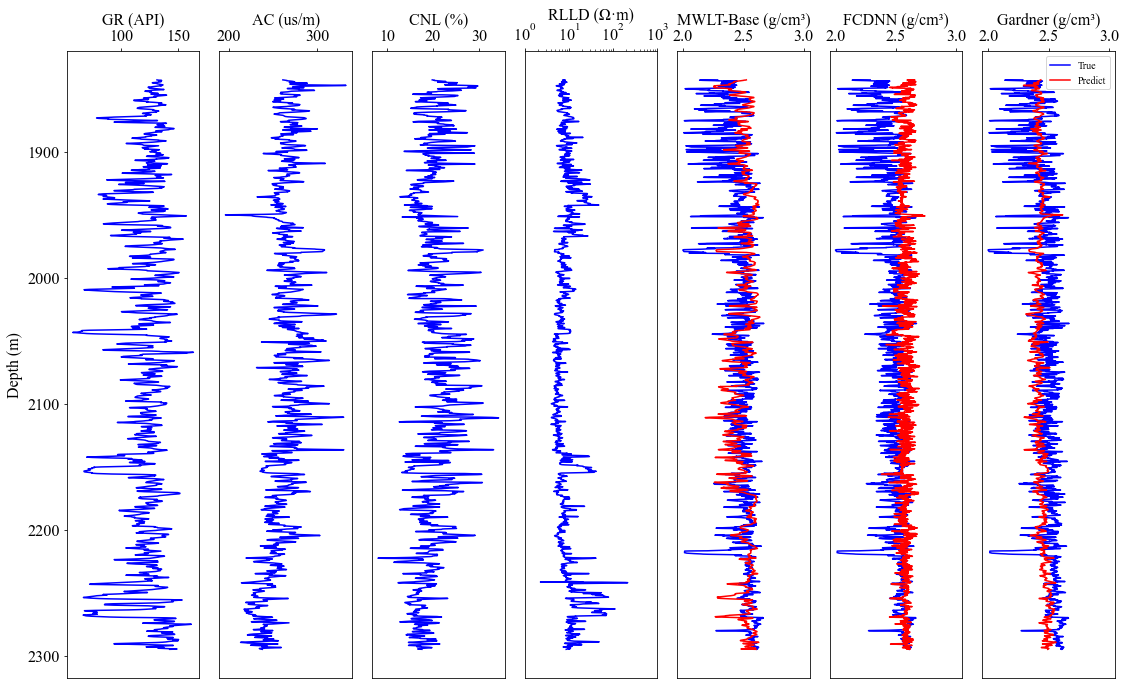

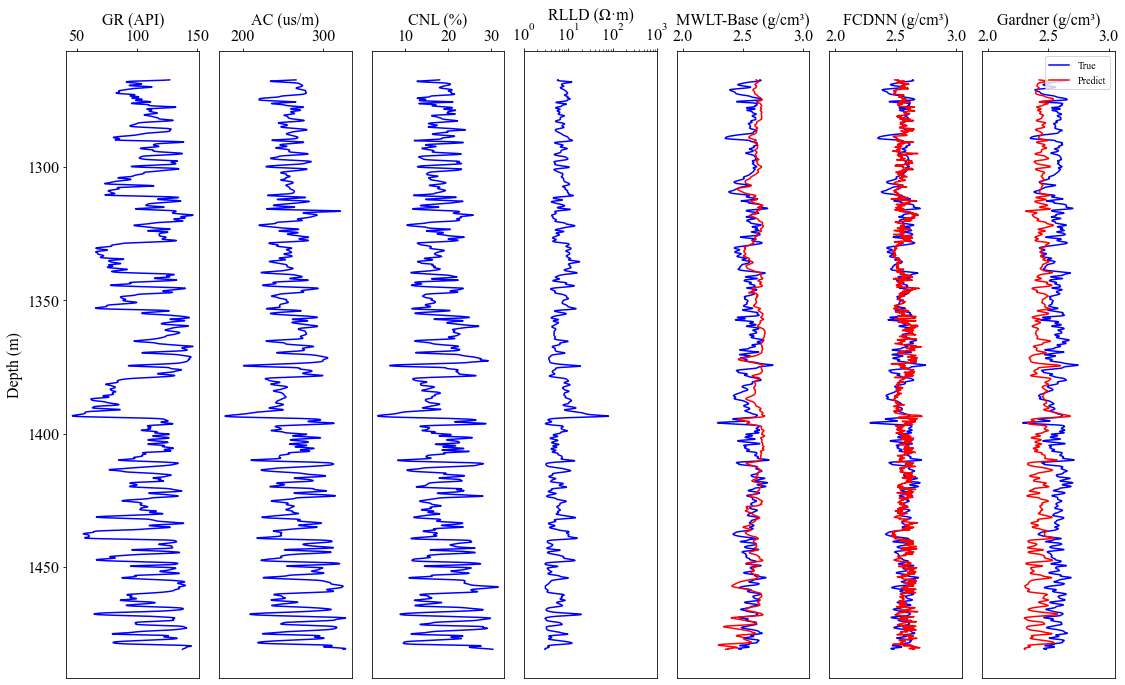

In [50]:
# 6.get figure result
plt_well_figure()

In [2]:
def cal_RMSE(pred, real):
    MSE = np.mean((pred - real) ** 2)
    RMSE = np.sqrt(MSE)
    return RMSE


def cal_MAPE(pred, real):
    mape = np.mean(abs((real - pred) / real))*100
    return mape


def cal_gardner():
    file_name = ["B1.hdf5", "B2.hdf5"]
    with open("gardner_indicators.txt", "w") as f_t:
        for file in file_name:
            f = h5py.File(file, mode="r")
            DEN = np.array(f.get("DEN"))
            f.close()
            f = h5py.File(file.split(".")[0] + "_" + "pred_gardner.hdf5", mode="r")
            pred = np.array(f.get("pred"))
            f.close()
            rmse = cal_RMSE(pred, DEN)
            mape = cal_MAPE(pred, DEN)
            f_t.write(file + " rmse:{},mape:{}\n".format(rmse, mape))
    f_t.close()


def cal_DNN_normal():
    file_name = ["B1.hdf5", "B2.hdf5"]
    with open("DNN_normal_indicators.txt", "w") as f_t:
        for file in file_name:
            f = h5py.File(file, mode="r")
            DEN = np.array(f.get("DEN"))
            f.close()
            f = h5py.File(file.split(".")[0] + "_" + "dnn_pred_normal.hdf5", mode="r")
            pred = np.array(f.get("pred"))
            f.close()
            pred = renormal_den(pred)
            rmse = cal_RMSE(pred, DEN)
            mape = cal_MAPE(pred, DEN)
            f_t.write(file + " rmse:{},mape:{}\n".format(rmse, mape))
    f_t.close()


def cal_transformer_base_normal():
    file_name = ["B1.hdf5", "B2.hdf5"]
    with open("transformer_base_pred_normal_indicators.txt", "w") as f_t:
        for file in file_name:
            f = h5py.File(file, mode="r")
            DEN = np.array(f.get("DEN"))
            f.close()
            f = h5py.File(file.split(".")[0] + "_" + "transformer_base_pred_normal.hdf5", mode="r")
            pred = np.array(f.get("pred"))
            f.close()
            pred = renormal_den(pred)
            rmse = cal_RMSE(pred, DEN)
            mape = cal_MAPE(pred, DEN)
            f_t.write(file + " rmse:{},mape:{}\n".format(rmse, mape))
    f_t.close()

In [6]:
# 7.Calculation of evaluation indicators
cal_gardner()
cal_DNN_normal()
cal_transformer_base_normal()